In [ ]:
# !pip3 install gurobipy
!pip3 install cvxpy

In [67]:
import scipy
import numpy as np
import torch
import torch.nn.functional as F
from functools import partial
from scipy.optimize import minimize, LinearConstraint

# import gurobipy as gp
# from gurobipy import GRB
import cvxpy


## Fixed vals
B = 30. ## float; cost by volume (inch-acre) of irrigation equipment
C = 8 ## int; total num crop types
A = 1500 ## float; total acres available;

crop_names = ["barley", "corn", "cotton", "hay", "oat", "peanut", "soybean", "wheat"]
assert C==len(crop_names)
r_mean = torch.tensor([21.653555, 26.3345, 39.3701, 30.9667,  21.653555, 23.62206, 22.637807, 21.653555], requires_grad=False) ## tensor float; required inches of water for each crop type
r_std = r_mean/20. # torch.ones(C)

## Environment vars; TODO sample from normal
R_mean = torch.tensor(13.6) ## float; inches of rainfall; pick a staet with a lower one for a more interesting problem case
R_std = 1.96129209111408 ## this is national
# m_mean = torch.tensor([315., 720, 680, 250, 500, 1050], requires_grad=False) ## tensor float; market prices of each crop type
# m_std = m_mean/30. #torch.ones(C)*1.5

price_mean = torch.tensor( [4.91798076923077, 4.76858974358974, 0.699292307692307, 165.839886039886, 3.33973372781065, 0.237182692307692, 10.788141025641, 5.65347692307692], requires_grad=False )
price_std = torch.tensor([0.320358618, 0.442035027, 0.053101146, 4.15450934, 0.415878254, 0.009781876, 1.331331178, 0.578177567], requires_grad=False )

yield_mean = torch.tensor([68.452, 158.62, 818.8, 2.408, 64.22, 3509.6, 44.84, 44.944], requires_grad=False )
yield_std = torch.tensor([7.008216606, 16.45260871, 75.25346061, 0.095175277, 4.176222376, 502.7385006, 5.106368573, 4.142772823], requires_grad=False )

## First stage vars
x = torch.tensor([A/C for _ in range(C)], requires_grad=True) ## acres of each crop type to plant
w = torch.tensor([ 10. ], requires_grad=True) ## float; additional total inches of water we want to be able to provide via irrigation
cvar_gamma = torch.tensor(0., requires_grad=True)
## Second stage vars
# h = torch.zeros(C) ## viable acres of harvest per crop type
# y = torch.zeros(C) ## additional inches of water to provide to each crop type

def sample_scenarios(B):
  R_batch = torch.normal(mean=R_mean.repeat(B,1), std=R_std)
  r_batch = torch.normal(
      mean=r_mean.repeat(B,1),
      std=r_std
  )
  price_batch = torch.normal(
      mean=price_mean.repeat(B,1),
      std=price_std
  )
  yield_batch = torch.normal(
      mean=yield_mean.repeat(B,1),
      std=yield_std
  )


  m_batch = price_batch*yield_batch

  r_batch = F.relu(r_batch)
  m_batch = F.relu(m_batch)

  return R_batch, r_batch, m_batch

def compute_batch_obj(
    curr_x, ## (C,)
    curr_w, ## (1,)
    curr_cvar_gamma,
    y_batch, ## (B,C)
    R_batch, ## (B,1)
    r_batch, ## (B,C) ; sampled
    m_batch, ## (B,C) ; sampled
    cvar_weight=0.,
    cvar_alpha=0.95,
):
  batch_size = y_batch.shape[0]
  x_batch = curr_x.unsqueeze(0) ## (1,C)
  w_batch = curr_w.unsqueeze(0) ## (1,1)
  obj_batch = (B*A*w_batch - torch.sum(
      x_batch * m_batch * torch.clamp( (R_batch+y_batch) / r_batch, max=1)
   , dim=1)) * 1e-6 ## (B,)

  obj = obj_batch.mean()
  if cvar_weight>0:
    cvar_batch = torch.clamp( obj_batch - curr_cvar_gamma, min=0) ## (B,)
    cvar_obj = curr_cvar_gamma + cvar_batch.mean() / (1-cvar_alpha)
    obj = (1.-cvar_weight)*obj + cvar_weight*cvar_obj
  return obj

def compute_batch_obj_dual(
    curr_x, ## (C,)
    curr_w, ## (1,)
    curr_cvar_gamma,
    y_batch, ## (B,C)
    R_batch, ## (B,1) ; sampled
    r_batch, ## (B,C) ; sampled
    m_batch, ## (B,C) ; sampled
    pi_batch, ## (B,) ; dual solution for the irrigation constraints
    cvar_weight=0.,
    cvar_alpha=0.95,
):
  batch_size = y_batch.shape[0]
  x_batch = curr_x.unsqueeze(0) ## (1,C)
  w_batch = curr_w.unsqueeze(0) ## (1,1)

  dual_part = torch.from_numpy(pi_batch)*( (x_batch*y_batch).sum(dim=1)- A*w) ## (B,)
  dual_part = dual_part.mean()

  return compute_batch_obj(
    curr_x, ## (C,)
    curr_w, ## (1,)
    curr_cvar_gamma,
    y_batch, ## (B,C)
    R_batch, ## (B,1)
    r_batch, ## (B,C) ; sampled
    m_batch, ## (B,C) ; sampled
    cvar_weight,
    cvar_alpha,
  ) + dual_part



def compute_batch_obj_ssp_cvxpy(
  y, x, w, cvar_gamma,
  R_sample,
  r_sample,
  m_sample,
  cvar_weight=0.,
  cvar_alpha=0.95,

):
  obj_batch = [
           -x[i].item()*m_sample[i].item() * cvxpy.minimum(1, (y[i]+R_sample)/ r_sample[i].item())* 1e-6 for i in range(C)
      ]
  obj = cvxpy.sum(
      obj_batch
  )
  if cvar_weight>0:
    cvar_batch = [ cvxpy.maximum( 0, curr_obj - cvar_gamma.item()) for curr_obj in obj_batch] ## (B,)
    cvar_obj = cvar_gamma.item() + cvxpy.sum(cvar_batch) / len(cvar_batch)/ (1-cvar_alpha)
    obj = obj*(1.-cvar_weight) + cvar_weight*cvar_obj

  return obj


'''
Algo outline

1. Init first-stage vars x and w
2. Repeat (num iter or tolerance exit condition):
  - Sample scenarios (batch size)
  - Solve second stage problem for h
  - Estimate gradient of first-stage vars x, w, then step
  - Project new x,w to first-stage constraint space

'''

batch_size = 64
max_iter = 200 #100
# lr = 1e2
param_groups = [
    {
    "params": x, "lr": 1e3
    },
    {
    "params": w,
    # "lr": 1e-6, ## good for non-cvar
    "lr": 1e0
    },
    {
    "params": cvar_gamma, "lr": 1e-2
    },
]
# params =[x,w,cvar_gamma]

optim_class = torch.optim.SGD
optim = optim_class(
    params=param_groups,
    # params=params,
    # lr=lr,
    momentum=0.9,
)

CVAR_WEIGHT = 0.5
CVAR_ALPHA = 0.95

obj_history = []
for i in range(max_iter):
  R_batch, r_batch, m_batch = sample_scenarios(batch_size)

  ## Solving SSPs
  y_batch = np.zeros((batch_size, C))
  pi_batch = np.zeros(batch_size)
  for j in range(batch_size):
    y = cvxpy.Variable(C, nonneg=True)
    objective = cvxpy.Minimize(
      compute_batch_obj_ssp_cvxpy(
        y, x.detach(), w.detach().item(), cvar_gamma.detach(),
        R_sample=R_batch[j],
        r_sample=r_batch[j],
        m_sample=m_batch[j],
        cvar_weight=CVAR_WEIGHT,
        cvar_alpha=CVAR_ALPHA,
      )
    )
    constraints = [
        sum([x[jj].item() * y[jj] for jj in range(C)]) <= A*w.detach().item()
    ]
    problem = cvxpy.Problem(objective, constraints)
    problem.solve()

    # print([y[jj].value for jj in range(C)])
    # print(constraints[0].dual_value)

    y_batch[j] = np.array([y[jj].value for jj in range(C)])
    pi_batch[j] = constraints[0].dual_value
  y_batch = torch.from_numpy(y_batch)
  # break

  ## Grad estimate and update step
  optim.zero_grad()
  obj = compute_batch_obj_dual(
    x, ## (C,)
    w, ## (1,)
    cvar_gamma,
    y_batch, ## (B,C)
    R_batch, ## (B,1)
    r_batch, ## (B,C) ; sampled
    m_batch, ## (B,C) ; sampled
    pi_batch, ## (B,)
    cvar_weight=CVAR_WEIGHT,
    cvar_alpha=CVAR_ALPHA,
  )
  obj.backward()
  # print(x.grad, w.grad)
  optim.step()

  with torch.no_grad():
    primal_obj = compute_batch_obj(
      x, ## (C,)
      w, ## (1,)
      cvar_gamma,
      y_batch, ## (B,C)
      R_batch, ## (B,1)
      r_batch, ## (B,C) ; sampled
      m_batch, ## (B,C) ; sampled
      cvar_weight=CVAR_WEIGHT,
      cvar_alpha=CVAR_ALPHA,
    ).detach().item()

  obj_history.append(primal_obj)

  ## Project to feasible x,w space
  if torch.any(x<0) or torch.any(w<0) or x.sum()>A:
    print("Outside feasible 1st stage set, computing projection...")

    def proj_obj(x_, w_):
      xx = x.detach().numpy()
      ww = w.detach().item()
      return cvxpy.sum([ (x_[ii] - xx[ii])**2  for ii in range(C)]) + (w_ - ww)**2 ## euclidean dist

    x_proj = cvxpy.Variable(C, nonneg=True)
    w_proj = cvxpy.Variable(nonneg=True)
    objective = cvxpy.Minimize(
      proj_obj(x_proj, w_proj),
    )
    constraints = [
        sum([x_proj[jj] for jj in range(C)]) <= A
    ]
    problem = cvxpy.Problem(objective, constraints)
    problem.solve()

    x_proj = torch.clamp( torch.tensor([x_proj[ii].value for ii in range(C)]), min=0, max=A)
    w_proj = torch.clamp( torch.tensor(w_proj.value), min=0,)
    with torch.no_grad():
      x.copy_(x_proj)
      w.copy_(w_proj)

  print(f"##### ITERATION {i}")
  print("x: " , x, x.grad)
  print("w: ", w.item(), w.grad)
  print("cvar_gamma: ", cvar_gamma.item(), cvar_gamma.grad)
  print("Obj val: ", primal_obj)
  print("#################")

  ## Convergence condition
  # if :
  #   break



Outside feasible 1st stage set, computing projection...
##### ITERATION 0
x:  tensor([187.4508, 187.6283, 187.4749, 187.4348, 187.3985, 187.6812, 187.5172,
        187.4143], requires_grad=True) tensor([-1.2331e-04, -3.0079e-04, -1.4737e-04, -1.0723e-04, -7.0937e-05,
        -3.5370e-04, -1.8972e-04, -8.6815e-05])
w:  9.985321044921875 tensor([0.0147])
cvar_gamma:  -0.004999999888241291 tensor(0.5000)
Obj val:  -0.1151646885950153
#################
Outside feasible 1st stage set, computing projection...
##### ITERATION 1
x:  tensor([187.3633, 187.8707, 187.4175, 187.3112, 187.2094, 188.0254, 187.5453,
        187.2571], requires_grad=True) tensor([-1.2245e-04, -2.9263e-04, -1.3090e-04, -1.0086e-04, -6.8023e-05,
        -3.4677e-04, -1.7819e-04, -8.5600e-05])
w:  9.958136558532715 tensor([0.0140])
cvar_gamma:  -0.014499999582767487 tensor(0.5000)
Obj val:  -0.1176487025733817
#################
Outside feasible 1st stage set, computing projection...
##### ITERATION 2
x:  tensor([187.2349

/usr/local/lib/python3.11/dist-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Outside feasible 1st stage set, computing projection...
##### ITERATION 139
x:  tensor([123.6126, 355.8958,  16.3421,  93.9224,  83.7721, 531.1956, 189.4839,
        105.7755], requires_grad=True) tensor([-1.5681e-04, -3.3091e-04, -4.2403e-05, -1.0723e-04, -1.2885e-04,
        -5.2539e-04, -1.7439e-04, -1.3656e-04])
w:  6.756569862365723 tensor([0.0037])
cvar_gamma:  -0.38405653834342957 tensor(-0.1250)
Obj val:  -0.41414223091958136
#################
Outside feasible 1st stage set, computing projection...
##### ITERATION 140
x:  tensor([123.3076, 356.6991,  14.9520,  93.2887,  83.2837, 533.5784, 189.5060,
        105.3846], requires_grad=True) tensor([-1.7130e-04, -2.9880e-04, -5.4052e-05, -1.1651e-04, -1.2626e-04,
        -4.1175e-04, -1.8519e-04, -1.3857e-04])
w:  6.78843355178833 tensor([-0.0027])
cvar_gamma:  -0.39283835887908936 tensor(0.0312)
Obj val:  -0.4530793848212714
#################
Outside feasible 1st stage set, computing projection...
##### ITERATION 141
x:  tensor([12

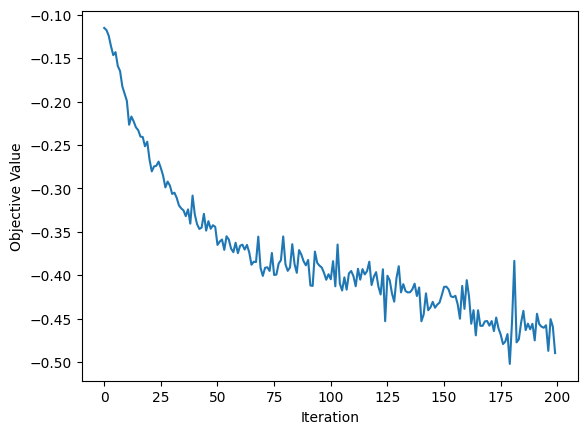

In [68]:
import matplotlib.pyplot as plt

plt.plot(range(len(obj_history)), obj_history)
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.show()